In [ ]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import pandas as pd
import tensorflow as tf
from tqdm import tqdm , tqdm_notebook
import numpy as np
import category_encoders as ce
import re
from copy import deepcopy
from MI import Gene_Missing
import matplotlib.pyplot as plt
import warnings , sys
warnings.filterwarnings('ignore')
sys.path.append('/home/advice/Python/SR/Custom/')
from utility import *
from Activations import *
from pyprnt import prnt as PrettyPrint


# autoimpute imports - imputations & analysis
from autoimpute.imputations import MultipleImputer

In [ ]:
RAW_ = pd.read_csv("/home/advice/Python/SR/Data/bank.csv", sep = ",")
usecols = RAW_.columns.tolist()
print(RAW_.shape)
print(RAW_.dropna().shape)
#RAW_ = RAW_.dropna().reset_index(drop=True)
RAW_.head()

In [ ]:
# for col in objcols :
#     print("{} : {}".format(col , RAW_[col].nunique()))

In [ ]:
st(RAW_)

In [ ]:
print(RAW_.columns.tolist())

In [ ]:
RAW = RAW_.copy()
RAW.shape

In [ ]:
RAW.head()

In [ ]:
# category = ["SEX" , "EDUCATION" , "MARRIAGE" ,
#             'PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6', 'default payment next month']
# RAW[category] = RAW[category].astype(str)

In [ ]:

obj_col = RAW.select_dtypes("object").columns.tolist()
ord_col = RAW.select_dtypes("int").columns.tolist()
num_col = RAW.select_dtypes("float").columns.tolist()
print(obj_col)
assert len(usecols) == len(obj_col + ord_col + num_col)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler(feature_range=(-1,1))
minmax.feature_range

## Missing 관련 정보 정리하기

In [ ]:
%load_ext autoreload
%autoreload 2
from MissInfo import MissInfo
missinfo = MissInfo(RAW , obj_col , num_col , ord_col , minmax)

In [ ]:
minmax.feature_range

In [ ]:
p_miss = 0.2
missinfo.fit()
trainX , testX , trainM , testM = missinfo.DL_train_test_split(0.7 , p_miss= p_miss ,
                                                               smooth = True , 
                                                               numpy= True)

In [ ]:
miss_info = missinfo.information()
print(list(miss_info.keys()))

In [ ]:
missing_sum = pd.DataFrame([np.sum(trainM , axis = 0) , np.sum(testM, axis = 0)])
m = pd.concat([missing_sum,pd.DataFrame(missing_sum.sum()).T]).T
m.columns = ["train","test", "sum"]
m["total"] = RAW.shape[0]
m["missing rate"] =np.round(m["sum"] / m["total"] * 100  , 2 )
m = m.T
m

In [ ]:
miss_info = missinfo.information()
print(list(miss_info.keys()))

In [ ]:
missinfo.info["obj_info"]

In [ ]:
ck = missinfo.ori_missing[0,:].astype(bool)
missinfo.ori_raw_pd.loc[:,ck].head(1)

In [ ]:
ck = missinfo.ori_transform_missing[0,:].astype(bool)
missinfo.ori_transform_pd.loc[:,ck].head(1)

In [ ]:
%load_ext autoreload
%autoreload 2
from Tensorflow_GainMI import Missing_GAIN as MG
from Tensorflow_AutoEncMI import Missing_AE

In [ ]:
missinfo.ori_transform_pd.shape

In [ ]:
len(miss_info["cat_num_idx_info"])

In [ ]:
len(miss_info["original_column"])

In [ ]:
Auto = Missing_AE(enc_dim = [35 , 30 , 20 , 20 , 15]  , dec_dim= [20,25,35,35, 45] ,
                  missing_info = miss_info , 
                  save_info_path= "./Bank_AE_missinfo_{}.pkl".format(p_miss) , 
                  save_model_path= './Bank_CAT_AE_{}/Model'.format(p_miss)  , gpu = 1) 
mb_size = 512
Auto.fit(trainX , trainM ,testX , testM , 
         mb_size , 
         epoch = 10000,
         Enc_act = tf_mish , 
         Dec_act = tf_mish ,
         weight_regularizer = 0,
         SN= False ,  lr = 0.005 ,
         patience = 10 ,
         cutoff = 1e-20 ,
         MetricLoss = False , 
        )

In [ ]:
Auto.train()

In [ ]:
mg = MG(gen_dim = [100, 90, 75 , 65 , 55 ]  , 
        dis_dim = [100, 90, 75 , 65 , 55 ] , 
        missing_info = miss_info , 
        save_info_path= "./Bank_GAIN_info_{}.pkl".format(p_miss),
        save_model_path= './Bank_CAT_GAIN_{}/Model'.format(p_miss),
        gpu = 0 , )
mb_size = 256
mg.fit(trainX , trainM ,testX , testM , mb_size , 
       hint = 0.9 ,
       Gact = tf_mish , 
       Dact = tf.nn.selu , 
       epoch = 10000, 
       alpha = 3.0 , 
       weight_regularizer = 0 ,
       SN = False ,
       max_norm = False , 
       lr = 0.002 , 
       patience = 20 ,
       cutoff = 1e-20
      )

In [ ]:
mg.train()

In [ ]:
mg.metric_plot(idx = 100)

In [ ]:
missing_matrix_RAW = miss_info["ori_transform_missing_matrix"]
missing_RAW = miss_info["ori_transform_pd"]
missing_matrix_ori_RAW = miss_info["ori_missing_matrix"]
missing_data = deepcopy(missing_RAW.values)
missing_data[missing_matrix_RAW == 1] = np.nan

In [ ]:
pd.DataFrame(missing_data , columns= miss_info["columns"]).head(2)

In [ ]:
missing_matrix_RAW

In [ ]:
AE_load_data = Auto.load_impute(save_file = './Bank_CAT_AE_{}/Model.meta'.format(p_miss) , 
                 file= "./Bank_CAT_AE_{}/".format(p_miss) ,
                 Data = missing_data , 
                 Missing = missing_matrix_RAW
                )

In [ ]:
MG_load_data = mg.load_impute(
    save_file = './Bank_CAT_GAIN_{}/Model.meta'.format(p_miss) , 
                 file= "./Bank_CAT_GAIN_{}/".format(p_miss) ,
                 Data = missing_data , 
                 Missing = missing_matrix_RAW
                )

In [ ]:
RAW_TRANS = Auto.transform(missing_RAW.values , num_inv_scaler= True)

In [ ]:
Auto.object_comparision(RAW_TRANS , AE_load_data)

In [ ]:
mg.object_comparision(RAW_TRANS , MG_load_data)

## Numerical 변수만 가지고 RMSE 비교

In [ ]:
print("AutoEncoder  : " ,  Auto.metric(RAW_TRANS , AE_load_data , 
                                     missing_matrix_RAW , standardize = False ,
                                       metric_type ="rmse" , 
                                     kf = None ) )

In [ ]:
print('GAIN : ' , mg.metric(RAW_TRANS , MG_load_data ,
                            missing_matrix_RAW , standardize = False,
                            metric_type ="rmse" , 
                            kf = None
                         )  )

In [ ]:
cc = RAW_TRANS.columns.tolist()
missing = pd.DataFrame(missing_matrix_RAW, columns =  miss_info["columns"])
for col in RAW_TRANS.columns.tolist() :
    if col in obj_col :
        cc.remove(col)

In [ ]:
from Imputation import Evaluate as EV
from sklearn.model_selection import KFold
kf = KFold(n_splits = 7) # Define the split - into 2 folds 
kf.get_n_splits(missing_data)
objcols = miss_info["obj_col"]
cc = RAW_TRANS.columns.tolist()
for col in RAW_TRANS.columns.tolist() :
    if col in obj_col :
        cc.remove(col)

raw = deepcopy(RAW_TRANS)
missing_matrix = deepcopy(missing_matrix_ori_RAW)
Imputation_BenchMark = EV(T = raw , 
                          kf = kf ,
                          mask= missing_matrix ,
                          obj = objcols ,
                          notobj = cc , 
                          target = "y" , 
                          miss_info= miss_info , 
                          algo =  ["MissForest","mean", "median" , 
                          "knn", "mode", "MICE"  , "EM" , ])

In [ ]:
Imputation_BenchMark.evaluate(standardize = False )

In [ ]:
Imputation_BenchMark.append_algo(name ="GAIN", 
                                 rmse = mg.metric(RAW_TRANS , MG_load_data  ,
                                           missing_matrix_RAW, standardize = False, 
                                           kf = kf.split(missing_data) ,
                                           metric_type = "rmse"
                                          ) , 
                                 nrmse = mg.metric(RAW_TRANS , MG_load_data  ,
                                           missing_matrix_RAW, standardize = False, 
                                           kf = kf.split(missing_data) ,
                                           metric_type = "nrmse"
                                          ) , 
                                 imputed= MG_load_data)
Imputation_BenchMark.append_algo(name = "AutoEncoder", 
                                 rmse = Auto.metric(RAW_TRANS , AE_load_data , 
                                           missing_matrix_RAW, standardize = False ,
                                           kf = kf.split(missing_data) , 
                                           metric_type = "rmse"
                                          ) , 
                                 nrmse = Auto.metric(RAW_TRANS , AE_load_data , 
                                           missing_matrix_RAW, standardize = False ,
                                           kf = kf.split(missing_data) , 
                                           metric_type = "nrmse"
                                          ) , 
                                 imputed= AE_load_data)

In [ ]:
Imputation_BenchMark.Outcome()

In [ ]:
Imputation_BenchMark.Predict_Comparision()

In [ ]:
from sklearn.metrics import f1_score , balanced_accuracy_score as bacc , accuracy_score 
Imputation_BenchMark.Measure_Vis(balanced_accuracy_score)

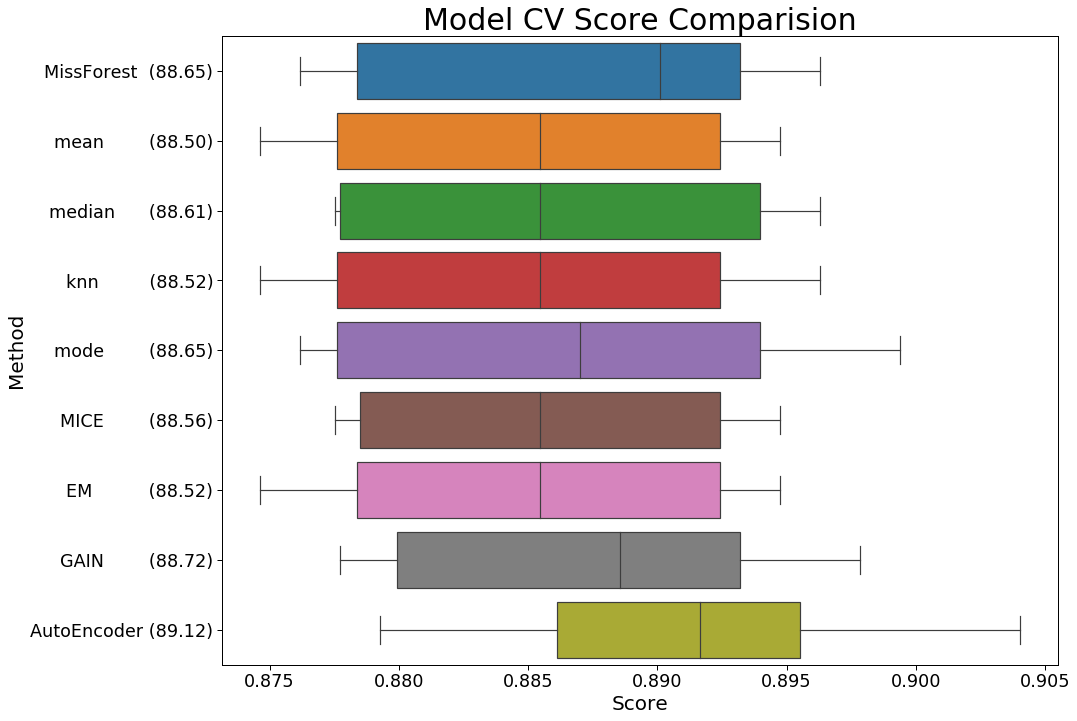

In [58]:
Imputation_BenchMark.Modeling_Measure_Vis(path = "./Bank_Vis_{}/Bank_Models_Comparision.png".format(p_miss))

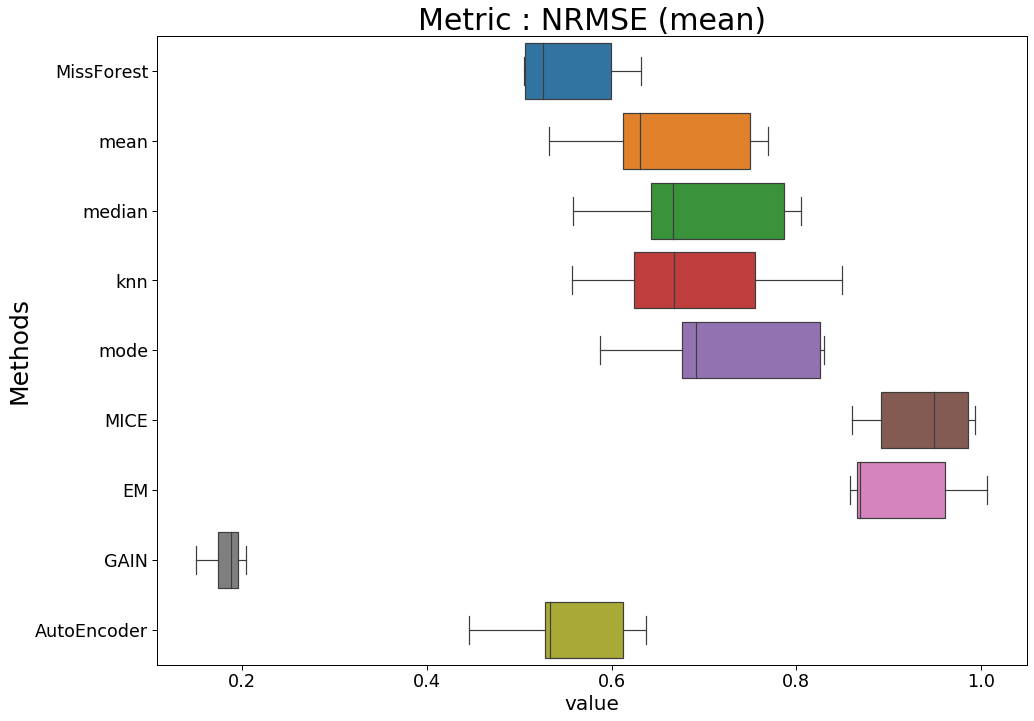

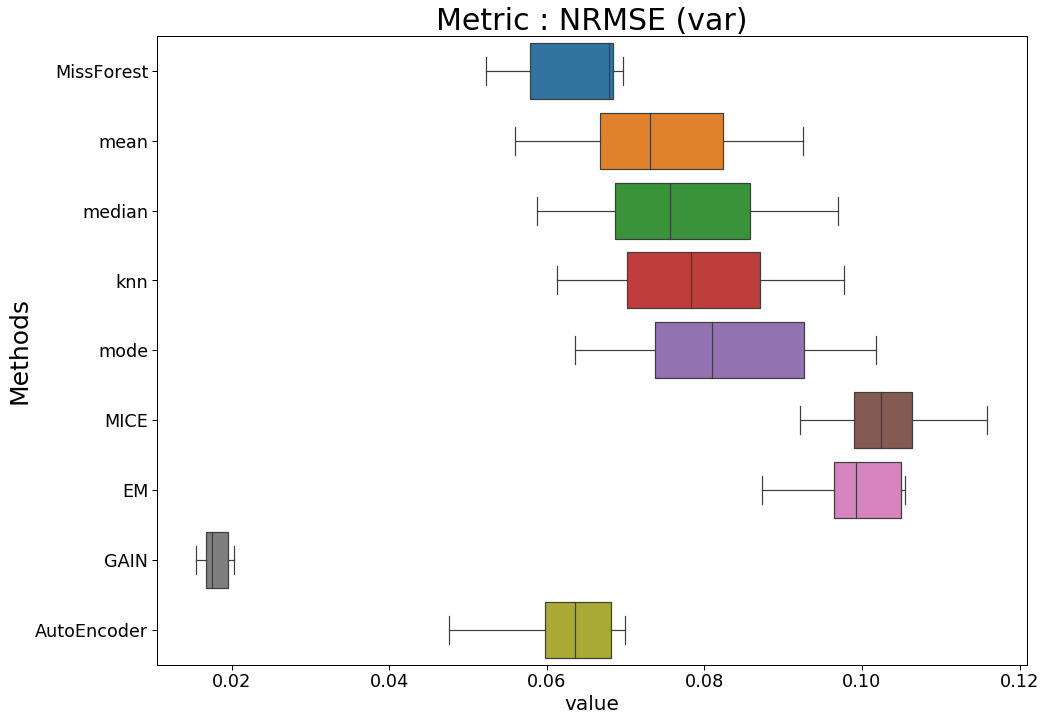

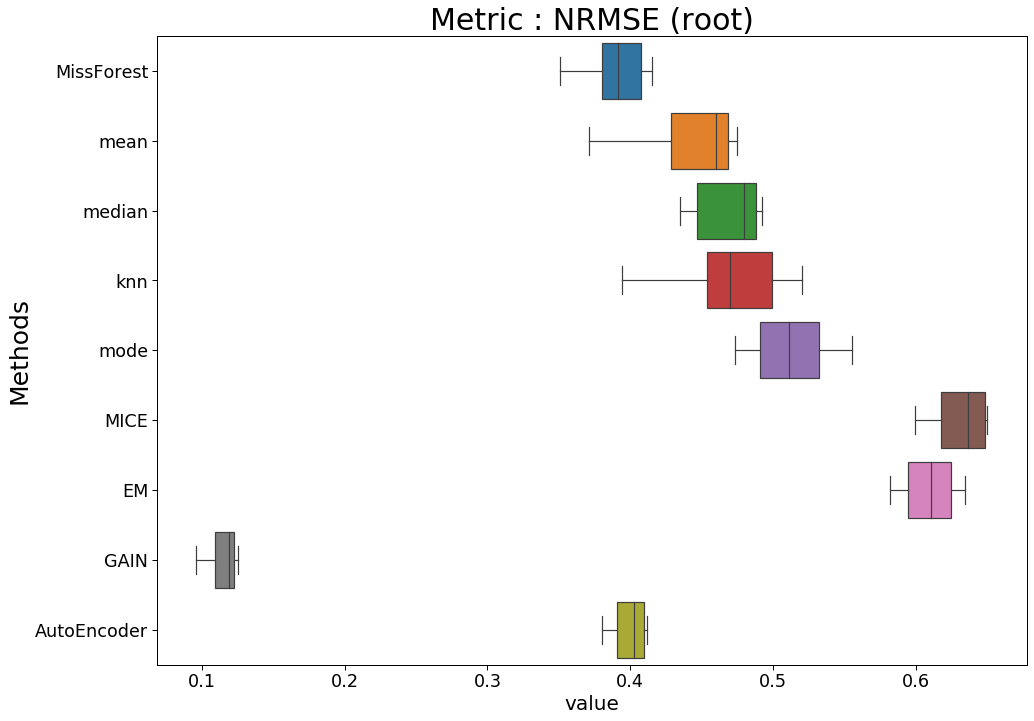

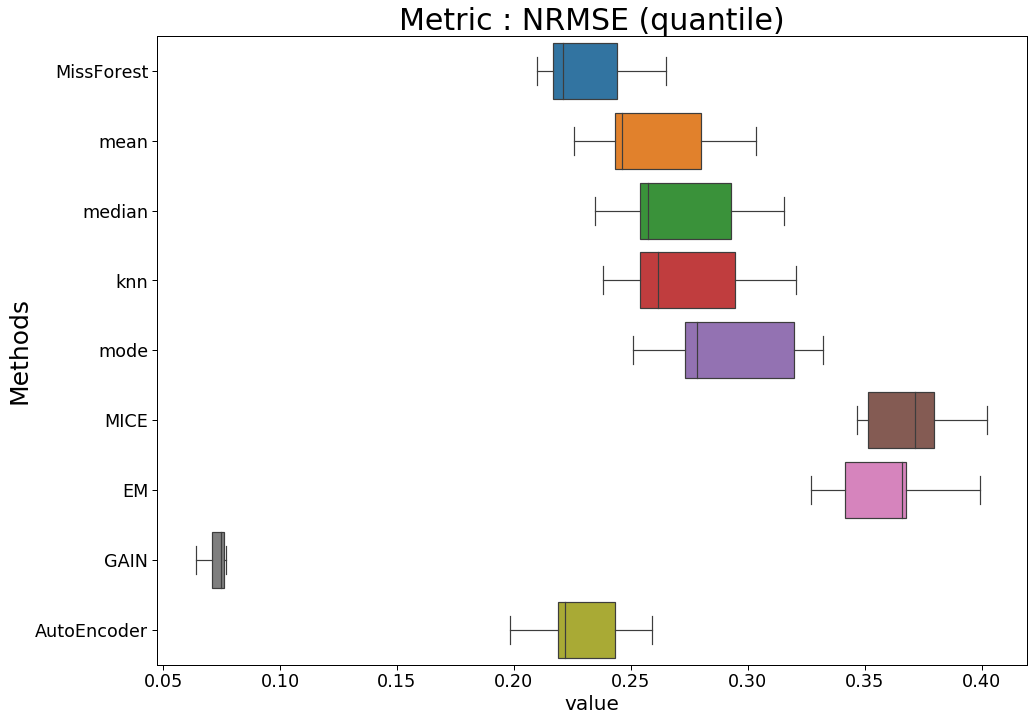

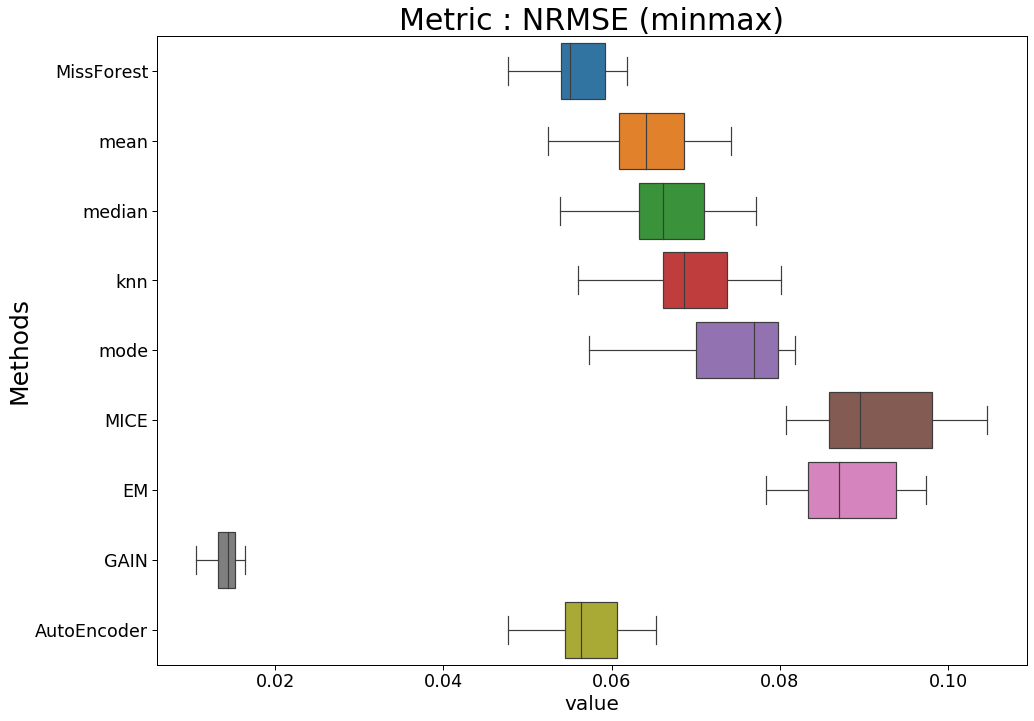

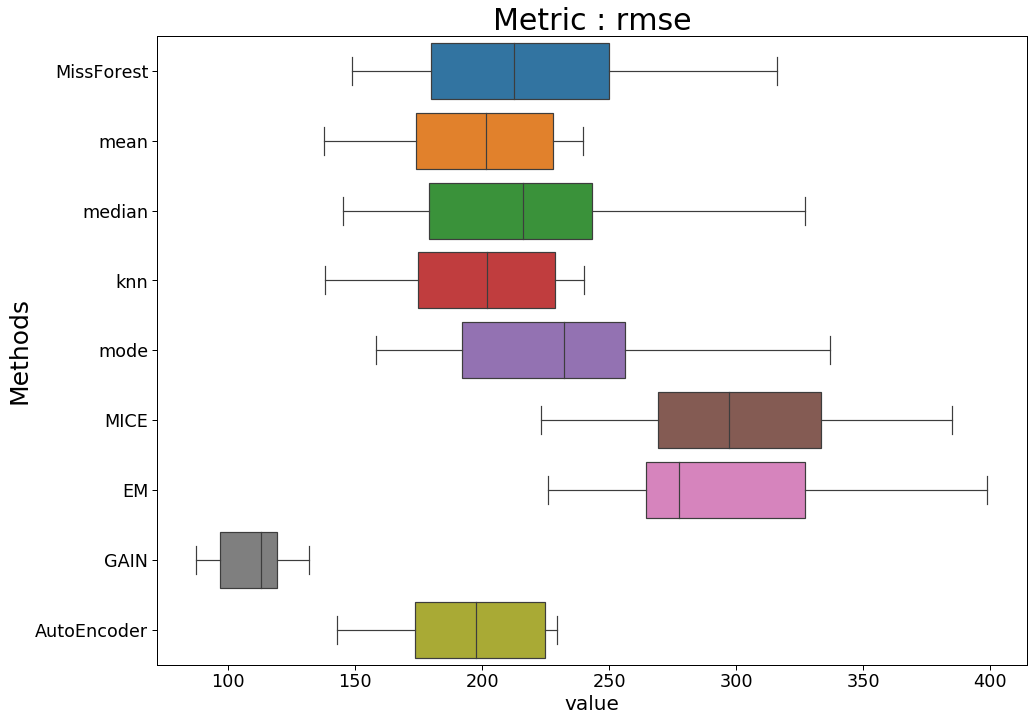

In [57]:
Imputation_BenchMark.cv_boxplot_all_run(path="./Bank_Vis_{}".format(p_miss))

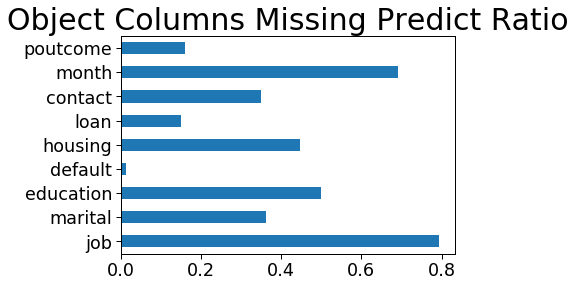

,N_not_correct,N_missing,PFC
job,747,940.0,0.794681
marital,309,851.0,0.363102
education,459,920.0,0.498913
default,12,913.0,0.013143
housing,393,880.0,0.446591
loan,141,935.0,0.150802
contact,308,883.0,0.348811
month,642,928.0,0.691810
poutcome,140,878.0,0.159453


In [56]:
Imputation_BenchMark.object_most_commom(None)

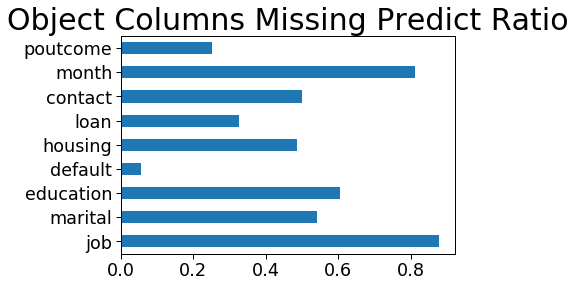

,N_not_correct,N_missing,PFC
job,827,940.0,0.879787
marital,460,851.0,0.540541
education,557,920.0,0.605435
default,52,913.0,0.056955
housing,428,880.0,0.486364
loan,306,935.0,0.327273
contact,442,883.0,0.500566
month,754,928.0,0.812500
poutcome,222,878.0,0.252847


In [50]:
Imputation_BenchMark.MICE_object_comparison(None)

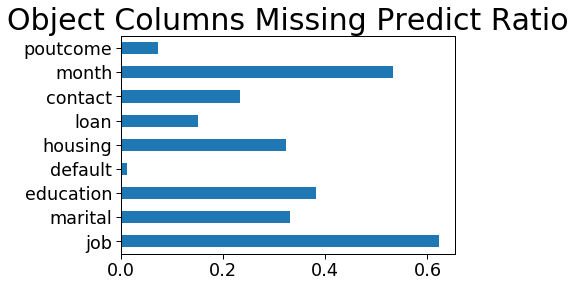

,N_not_correct,N_missing,PFC
job,586,940.0,0.623404
marital,282,851.0,0.331375
education,351,920.0,0.381522
default,12,913.0,0.013143
housing,285,880.0,0.323864
loan,141,935.0,0.150802
contact,206,883.0,0.233296
month,495,928.0,0.533405
poutcome,64,878.0,0.072893


In [51]:
Imputation_BenchMark.Missforest_object_comparision("./")

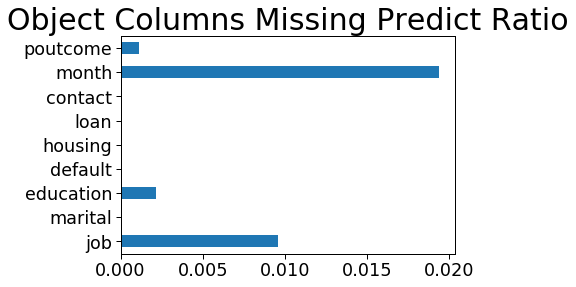

,N_not_correct,N_missing,PFC
job,9,940.0,0.009574
marital,0,851.0,0.000000
education,2,920.0,0.002174
default,0,913.0,0.000000
housing,0,880.0,0.000000
loan,0,935.0,0.000000
contact,0,883.0,0.000000
month,18,928.0,0.019397
poutcome,1,878.0,0.001139


In [52]:
mg.object_comparision(RAW_TRANS , MG_load_data, target = "y")

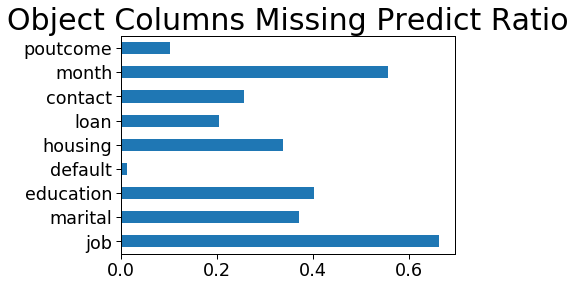

,N_not_correct,N_missing,PFC
job,623,940.0,0.662766
marital,315,851.0,0.370153
education,370,920.0,0.402174
default,12,913.0,0.013143
housing,297,880.0,0.337500
loan,192,935.0,0.205348
contact,226,883.0,0.255946
month,515,928.0,0.554957
poutcome,90,878.0,0.102506


In [53]:
Auto.object_comparision(RAW_TRANS , AE_load_data, target = "y")

In [54]:
Imputation_BenchMark.show_result( row_m= 4 , n = 1)

,algo,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,missing,1,1,0,0,0,0,0,0,1,1,1,0,1,0,1,0,0
1,True,35,technician,,,,0,,,cellular,26,aug,0,2,-0,0,,
2,MissForest,43.9549,management,,,,0,,,cellular,10.3237,aug,0,2.07027,-0,0,,
3,mean,40.7992,management,,,,0,,,cellular,15.7786,may,0,2.71023,-0,0.580517,,
4,median,38,management,,,,0,,,cellular,16,may,0,2,-0,0,,
5,knn,40.9039,management,,,,0,,,cellular,9.83436,may,0,2.11709,-0,0.201335,,
6,mode,33,management,,,,0,,,cellular,18,may,0,1,-0,0,,
7,MICE,27.5859,admin.,,,,0,,,unknown,6.22157,may,0,4.92807,-0,1.22575,,
8,EM,47.6319,management,,,,0,,,cellular,12.7701,may,0,1.75056,-0,0.181719,,
9,GAIN,38.1157,technician,,,,0,,,cellular,26.2917,aug,0,1.95865,-0,4.39584e-05,,


In [55]:
Imputation_BenchMark.save_result("./Bank_Vis_{}/Bank_Info.pkl".format(p_miss))

## Category 변수와 같이 학습을 시키면 Numeric 변수의 성능이 떨어진다....
 

In [ ]:
# Imputation_BenchMark.save_result("./BenckMark_Bank_result")
# Imputation_BenchMark.plot(figsize = (10 , 9) , 
#                           metric = "rmse" ,
#                           img_name="./BenchMark_Bank.png")

In [ ]:
# Imputation_BenchMark.save_result("./BenckMark_Bank_result")
# Imputation_BenchMark.plot(figsize = (10 , 9) , 
#                           metric = "nrmse" ,
#                           img_name="./BenchMark_Bank.png")

In [ ]:
# Imputation_BenchMark.re_metric(mode = "standardize" )
# Imputation_BenchMark.plot(figsize = (10 , 9) , img_name="./BenchMark_Bank.png")
# Imputation_BenchMark.re_metric(mode = "inverse" )
# Imputation_BenchMark.plot(figsize = (10 , 9) , img_name="./BenchMark_Bank_inverse.png")